# Tensor Network

In [25]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,"../")
import data_generator as gen

#import TensorNetwork as tn
import Network_class as tn

from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from importlib import reload

In [27]:
class NumpyDataset(Dataset):
    """
    Add description
    """
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [28]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    """
    Add description
    """
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=True, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

## Example of training

In [37]:
n_samples = 5000
linear_dim = 8
M = 10
#B = int((n_samples-128)/3)
B = n_samples - 128

In [38]:
(data, label) = gen.create_dataset(n_samples, linear_dim=linear_dim, sigma=0.6)
batch_size = {'train_batch_size':B, 'val_batch_size':128, 'test_batch_size':1}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 1, 128/n_samples, **batch_size)

In [39]:
reload(tn)

<module 'Network_class' from '/home/francesco/UNIPD/Information_Theory/TensorNetworkForML/TensorNetwork/Network_class.py'>

In [40]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [41]:
N = linear_dim**2
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration)

Normalizing weights...
Scaling factor: 6.40
Calibrating weights on dataset...
f_max for random input of 4872 samples :  2.304058188453817
Rescaling factor for calibration:  1.0131271645030429
f_max for random input of 4872 samples (after):  0.9999999999999937


In [42]:
from custom_linalg_tools import contract
B = contract(net.As[0], net.As[1], "right", "left")
loss_term, derivate = net.compute_L2_reg(B, 0.1)
print(loss_term)
print(derivate)

152.8895396875864
========== Tensor description ==========
Tensor shape:  (2, 2, 2, 10)
Tensor rank:  4
Axes names:  ['l' 'd0' 'd1' 'right']



In [43]:
n_epochs = 5
train_acc, val_acc, var_hist = net.train(train_loader, val_loader, lr = 0.01, n_epochs = n_epochs, weight_dec=1, print_freq=100)

Epoch 0 - train accuracy : 0.2381 - val accuracy: 1.0000 
Epoch 1 - train accuracy : 1.0000 - val accuracy: 0.9453 
Epoch 2 - train accuracy : 0.9394 - val accuracy: 1.0000 
Epoch 3 - train accuracy : 0.9961 - val accuracy: 0.9766 
Epoch 4 - train accuracy : 0.9663 - val accuracy: 0.9297 



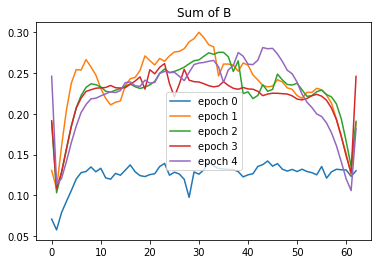

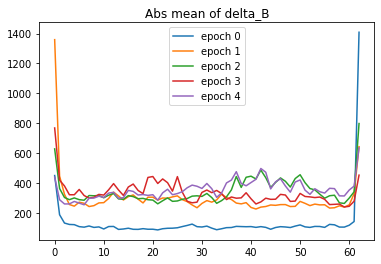

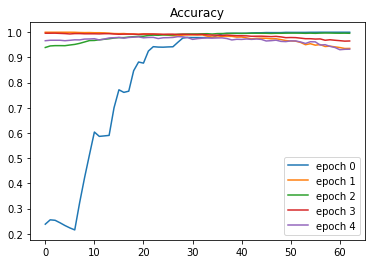

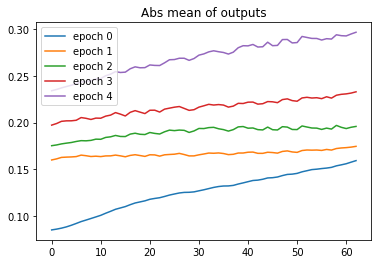

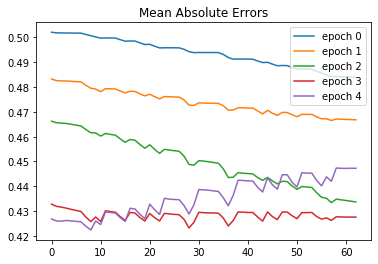

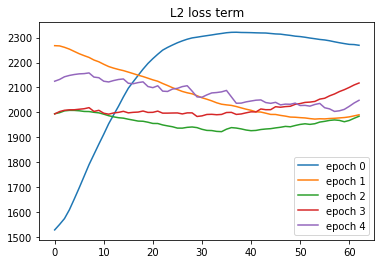

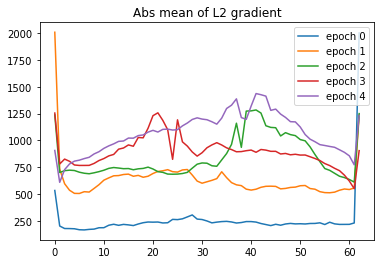

In [44]:
# Plot history of B, delta_B and accuracy
#plt.plot(var_hist[0][0] + var_hist[1][0], label="epoch 1 and 2")
#plt.plot(var_hist[2][0] + var_hist[3][0], label="epoch 3 and 4")
for i in range(n_epochs):
    plt.plot(var_hist[i][0], label="epoch "+str(i))
plt.title("Sum of B")
plt.legend()
plt.show()

#plt.plot(var_hist[0][1] + var_hist[1][1], label="epoch 1 and 2")
#plt.plot(var_hist[2][1] + var_hist[3][1], label="epoch 3 and 4")
for i in range(n_epochs):
    plt.plot(var_hist[i][1], label="epoch "+str(i))
plt.title("Abs mean of delta_B")
plt.legend()
plt.show()

#plt.plot(var_hist[0][2] + var_hist[1][2], label="epoch 1 and 2")
for i in range(n_epochs):
    plt.plot(var_hist[i][2], label="epoch "+str(i))
plt.title("Accuracy")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][3], label="epoch "+str(i))
plt.title("Abs mean of outputs")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][4], label="epoch "+str(i))
plt.title("Mean Absolute Errors")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][5], label="epoch "+str(i))
plt.title("L2 loss term")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][6], label="epoch "+str(i))
plt.title("Abs mean of L2 gradient")
plt.legend()
plt.show()

In [45]:
data = next(iter(train_loader))
x = np.array([data[i][0] for i in range(len(data))])
y = np.array([data[i][1] for i in range(len(data))])
y[:15]

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [46]:
f = net.forward(x)
print(f.elem.shape)
y_pred = np.argmax(f.elem, axis=0)
y_pred[:15]

(2, 4872)


array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1])

In [113]:
net.accuracy(x,y)

1.0

# Time profiling

In [ ]:
import time

## Scaling in the number of samples

In [ ]:
n_samples = [1000*i**2 for i in range(1,9)]
print("Number of samples tried: \n", n_samples)

# keep them fixed
linear_dim = 5
M = 20

In [ ]:
times_n_samples = []
for n in n_samples:
    print("Testing with %d samples..."%n)
    (data, label) = gen.create_dataset(n, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_n_samples.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(n_samples, times_n_samples, '-o', label='M = %d \nlinear dim = %d'%(M,linear_dim))
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{samples}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the number of pixels

In [ ]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
times_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_linear_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(linear_dims**2, times_linear_dims, '-o', label='M = %d \nnum samples = %d'%(M,n_samples))
plt.xlabel("Number of pixels", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{pixels}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the bond dimension

In [ ]:
Ms = [10*i for i in range(1,11)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
times_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_bond_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, times_bond_dims, '-o', label='linear dim = %d \nnum samples = %d'%(linear_dim,n_samples))
plt.xlabel("Bond dimension", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title("Training time vs bond dimension", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Weight initialization

**Objective:** study what is the dependence in the output magnitude of the various dimensions so that we can choose how to normalize the matrices A during initialization.

**Parameters:**
* Number of pixels N
* Bond dimension M
* Batch size B
* Embedding dimension D (fixed to 2)

Only the first 3 will be inquired.

**Methodology:** Use random input in [0,1] and random initialization in [0,1] for different dimensions and look at the absolute value of the output (take the output among the L with the highest absolute value).

In [ ]:
from importlib import reload
reload(tn)

### Dependence on the number of pixels N

In [ ]:
linear_dims = np.arange(4,16)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

As we can see the dependence on N is exponential, meaning that we can have an exponential suppression (or divergence) if the network is not accurately initialized.

### Isolating dependence C(N)

In [ ]:
y_scaled = y - Ns*np.log10(M)
X = Ns.reshape(-1,1)
reg_C = LinearRegression().fit(X, y_scaled)
plt.figure(figsize=(8,6))
plt.plot(Ns, y_scaled, label = 'data')
plt.plot(Ns, reg_C.predict(X), label = 'slope = %.2f'%reg_C.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
1/(10**(-0.18))

### Bond dimension M

In [ ]:
Ms = [5*i for i in range(1,21)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
magnitude_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim=linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_bond_dims.append(f_max)

In [ ]:
y = np.log10(magnitude_bond_dims)
X = np.log10(np.array(Ms)).reshape(-1,1)
reg_M = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(X, y, label = 'data')
plt.plot(X, reg_M.predict(X), label = 'slope = %.3f'%reg_M.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Bond dimension $log_{10}(M)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
print(10**reg_M.intercept_)

The output magnitude has a power law dependence on the bond dimension. Notice how the slope is equal to N.
This makes sense since we already know that f is exponential in N. Now we also can approximate the scaling of the f as:
$$f \approx C(N)*M^N$$

### Batch dimension B

In [ ]:
M = 20
n_samples = 1000
linear_dim = 5

train_batch_sizes = np.array([2**i for i in range(1,10)])

In [ ]:
magnitude_batch_size = []
for B in train_batch_sizes:
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size': int(B), 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_batch_size.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_batch_sizes, magnitude_batch_size, label = 'data')
plt.ylabel(r'$f_{max}$', fontsize = 16)
plt.xlabel('Batch size B', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

No clear dependence emerges on the batch size.

### Conclusion on initialization

The simplest and most reliable initialization is the one that takes into account the number of pixels given as input and disregards all the rest. However remains the problem of choosing the factor with which the weights should be divided. To find an exact factor a priori is not immediate and is also a risky procedure, hence it's better to devise an empirical method to do so.



In [ ]:
linear_dim = 5
n_samples = 1000
M = 10

In [ ]:
reload(tn)

In [ ]:
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C = []
for C in Cs:
    
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)
    
    for i in range(net.N):
        net.As[i].elem *= C
    
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    print('f_max: ', f_max)
    magnitude_C.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
X = np.log10(Cs).reshape(-1,1)
y = np.log10(np.array(magnitude_C))
y = y/y[0]
reg_scale = LinearRegression().fit(X, y)
plt.plot(X, y, label='data')
plt.plot(X, reg_scale.predict(X), label = 'slope = %.2f\nintercept = %.2f'%(reg_scale.coef_,reg_scale.intercept_))
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Scaling factor $log_{10}(C)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
Ms = np.array([5*i for i in range(1,21)])
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C_M = []
for M in Ms:
    magnitude_C = []
    for C in Cs:

        net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)

        for i in range(net.N):
            net.As[i].elem *= C

        f = net.forward(X)
        f_max = np.abs(f.elem).max()
        magnitude_C.append(f_max)
        
    magnitude_C = np.array(magnitude_C)
    magnitude_C_M.append(magnitude_C)
    
magnitude_C_M = np.array(magnitude_C_M)

In [ ]:
magnitude_C_M.shape

In [ ]:
alphas = []
for i,M in enumerate(Ms):
    X = np.log10(Cs).reshape(-1,1)
    y = np.log10(np.array(magnitude_C_M[i,:]))
    y = y/y[0]
    reg = LinearRegression().fit(X, y)
    alphas.append(reg.coef_)
alphas = np.array(alphas)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, alphas)
plt.xlabel('Bond dimension M', fontsize=16)
plt.ylabel(r'$\alpha$ coefficient', fontsize=16)
plt.show()

In [48]:
reload(tn)

<module 'TensorNetwork' from '/home/francesco/UNIPD/Information_Theory/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [49]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

Linear dimensions tested: 
 [ 4  8 12 16 20 24 28]


In [50]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=True)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

Testing with 4 x 4 images...
Normalizing weights...
Scaling factor: 12.80
Calibrating weights on dataset...
f_max for random input of 16 samples :  1.6712556430879646
Rescaling factor for calibration:  1.0326191633351856
f_max for random input of 16 samples (after):  1.6712556430879646
Testing with 8 x 8 images...
Normalizing weights...
Scaling factor: 12.80
Calibrating weights on dataset...
f_max for random input of 16 samples :  1.7318445003579228
Rescaling factor for calibration:  1.0086179699993059
f_max for random input of 16 samples (after):  1.7318445003579228
Testing with 12 x 12 images...
Normalizing weights...
Scaling factor: 12.80
Calibrating weights on dataset...
f_max for random input of 16 samples :  1.1647029409294452
Rescaling factor for calibration:  1.0010593528583895
f_max for random input of 16 samples (after):  1.1647029409294452
Testing with 16 x 16 images...
Normalizing weights...
Scaling factor: 12.80
Calibrating weights on dataset...
f_max for random input of 1

KeyboardInterrupt: 

In [ ]:
u = np.random.random(10000)
x = np.cos(np.pi/2*u)
x.mean()

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

### Gradient clipping
**Idea**: 

# MNIST dataset

In [47]:
import skimage.measure

def pooling(X):
    X = skimage.measure.block_reduce(X, (1,2,2), np.max)
    return X

In [57]:
MNIST_data = gen.get_MNIST_dataset(data_root_dir = './datasets', download=False)
train_data, train_labels, test_data, test_labels = MNIST_data
data = np.concatenate((train_data,test_data))
data = pooling(pooling(data))
labels = np.concatenate((train_labels,test_labels))

# We before building dataset, we try binary classification with mnist                        
#batch_size = {'train_batch_size':32, 'val_batch_size':128, 'test_batch_size':128}
#train_loader, val_loader, test_loader = prepare_dataset(data, labels, 6/7, 0.2, **batch_size)

In [58]:
# Extract only 0s and 1s from dataset
mask1 = (labels == 0) 
mask2 = (labels == 1)
mask = mask1 + mask2
labels01 = labels[mask]
data01 = data[mask]

train_batch = int( len(data01) * (0.8) )

batch_size = {'train_batch_size':train_batch, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data01, labels01, 1, 0.2, **batch_size)

In [59]:
reload(tn)

<module 'Network_class' from '/home/francesco/UNIPD/Information_Theory/TensorNetworkForML/TensorNetwork/Network_class.py'>

In [60]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [73]:
#net = tn.Network(N=196, M=20, L=2, normalize=True, calibration_X=x_calibration) #, sigma=0.23)
net = tn.Network(N=49, M=20, L=2, normalize=True, calibration_X=x_calibration) #, sigma=0.23)

Normalizing weights...
Scaling factor: 12.80
Calibrating weights on dataset...
f_max for random input of 11824 samples :  4.6403041561824144e-07
Rescaling factor for calibration:  0.7425844417647566
f_max for random input of 11824 samples (after):  1.0000000000000013


In [74]:
n_epochs = 4
train_acc, val_acc, var_hist = net.train(train_loader, val_loader, lr=0.1, n_epochs=n_epochs, weight_dec=0.001, print_freq=100)

Epoch 0 - train accuracy : 0.5008 - val accuracy: 0.4973 
Epoch 1 - train accuracy : 0.5008 - val accuracy: 0.5000 
Epoch 2 - train accuracy : 0.4996 - val accuracy: 0.5034 
Epoch 3 - train accuracy : 0.4992 - val accuracy: 0.5027 



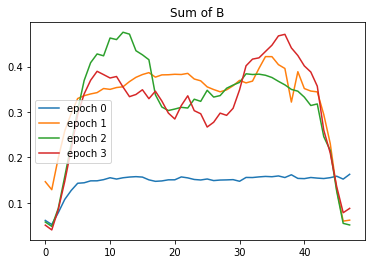

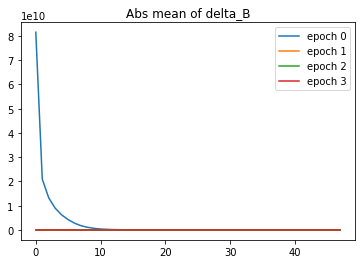

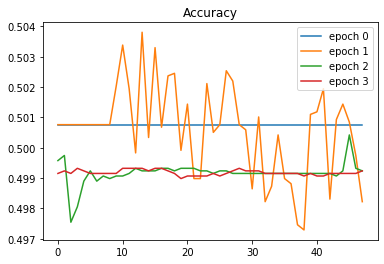

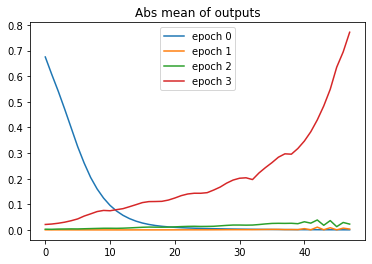

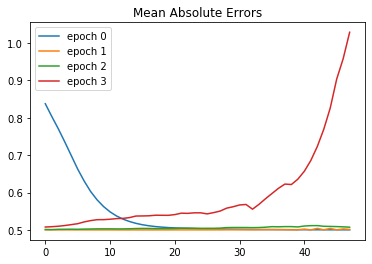

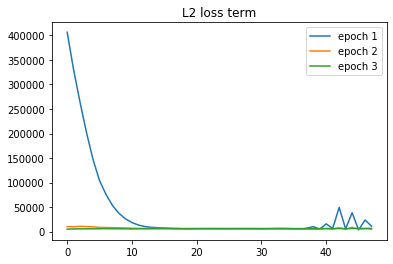

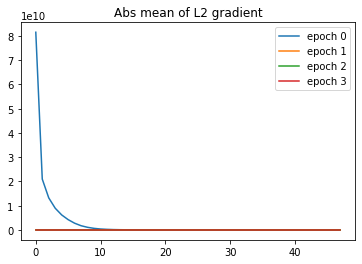

In [76]:
# Plot history of B, delta_B and accuracy
#plt.plot(var_hist[0][0] + var_hist[1][0], label="epoch 1 and 2")
#plt.plot(var_hist[2][0] + var_hist[3][0], label="epoch 3 and 4")
for i in range(n_epochs):
    plt.plot(var_hist[i][0], label="epoch "+str(i))
plt.title("Sum of B")
plt.legend()
plt.show()

#plt.plot(var_hist[0][1] + var_hist[1][1], label="epoch 1 and 2")
#plt.plot(var_hist[2][1] + var_hist[3][1], label="epoch 3 and 4")
for i in range(n_epochs):
    plt.plot(var_hist[i][1], label="epoch "+str(i))
plt.title("Abs mean of delta_B")
plt.legend()
plt.show()

#plt.plot(var_hist[0][2] + var_hist[1][2], label="epoch 1 and 2")
for i in range(n_epochs):
    plt.plot(var_hist[i][2], label="epoch "+str(i))
plt.title("Accuracy")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][3], label="epoch "+str(i))
plt.title("Abs mean of outputs")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][4], label="epoch "+str(i))
plt.title("Mean Absolute Errors")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][5], label="epoch "+str(i))
plt.title("L2 loss term")
plt.legend()
plt.show()

for i in range(n_epochs):
    plt.plot(var_hist[i][6], label="epoch "+str(i))
plt.title("Abs mean of L2 gradient")
plt.legend()
plt.show()

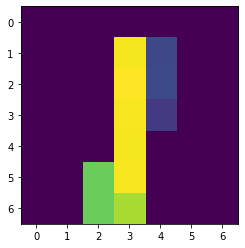

(7, 7)

In [62]:
n = 37
plt.imshow(data01[n])
plt.show()
labels01[n]

data01[n].shape